In [67]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


In [98]:
pip install --upgrade tf_slim

     |████████████████████████████████| 352 kB 2.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import tensorflow as tf
import numpy as np
import cv2
import random
import scipy.misc
import tf_slim as slim
import matplotlib.pyplot as plt
from utils import *

In [12]:
cv2.imread("/Users/conueyn/Documents/Science Research/Total Images/0001.jpg").shape

(512, 512, 3)

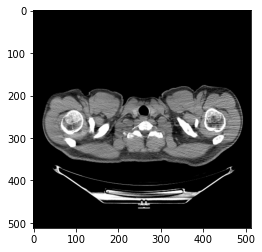

In [13]:
DATADIR = "/Users/conueyn/Documents/Science Research/Total Images"

path = DATADIR

for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img))
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break

In [14]:
print(img_array.shape)

(512, 512, 3)


In [15]:
HEIGHT, WIDTH, CHANNEL = 128, 128, 3
BATCH_SIZE = 64
EPOCH = 5000
version = 'newCT'
newCT_path = './' + version

def lrelu(x, n, leak=0.2): 
    return tf.maximum(x, leak * x, name=n) 

In [16]:
def process_data():
    current_dir = "/Users/conueyn/Documents/Science Research"
    # parent = os.path.dirname(current_dir)
    image_dir = os.path.join(current_dir, 'Total Images')
    images = []
    for each in os.listdir(image_dir):
        images.append(os.path.join(image_dir,each))
    all_images = tf.convert_to_tensor(images, dtype = tf.string)
    
    images_queue = tf.train.slice_input_producer([all_images])
    
    content = tf.read_file(images_queue[0])
    image = tf.image.decode_jpeg(content, channels = CHANNEL)
    # sess1 = tf.Session()
    # print sess1.run(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.1)
    image = tf.image.random_contrast(image, lower = 0.9, upper = 1.1)
    
    size = [HEIGHT, WIDTH]
    image = tf.image.resize_images(image, size)
    image.set_shape([HEIGHT,WIDTH,CHANNEL])
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    
    iamges_batch = tf.train.shuffle_batch(
                                    [image], batch_size = BATCH_SIZE,
                                    num_threads = 4, capacity = 200 + 3* BATCH_SIZE,
                                    min_after_dequeue = 200)
    num_images = len(images)

    return iamges_batch, num_images

In [17]:
def generator(input, random_dim, is_train, reuse=False):
    c4, c8, c16, c32, c64 = 512, 256, 128, 64, 32 # channel num
    s4 = 4
    output_dim = CHANNEL  # RGB image
    with tf.variable_scope('gen') as scope:
        if reuse:
            scope.reuse_variables()
        w1 = tf.get_variable('w1', shape=[random_dim, s4 * s4 * c4], dtype=tf.float32,
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b1 = tf.get_variable('b1', shape=[c4 * s4 * s4], dtype=tf.float32,
                             initializer=tf.constant_initializer(0.0))
        flat_conv1 = tf.add(tf.matmul(input, w1), b1, name='flat_conv1')
         #Convolution, bias, activation, repeat! 
        conv1 = tf.reshape(flat_conv1, shape=[-1, s4, s4, c4], name='conv1')
        bn1 = tf.contrib.layers.batch_norm(conv1, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn1')
        act1 = tf.nn.relu(bn1, name='act1')
        # 8*8*256
        #Convolution, bias, activation, repeat! 
        conv2 = tf.layers.conv2d_transpose(act1, c8, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name='conv2')
        bn2 = tf.contrib.layers.batch_norm(conv2, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn2')
        act2 = tf.nn.relu(bn2, name='act2')
        # 16*16*128
        conv3 = tf.layers.conv2d_transpose(act2, c16, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name='conv3')
        bn3 = tf.contrib.layers.batch_norm(conv3, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn3')
        act3 = tf.nn.relu(bn3, name='act3')
        # 32*32*64
        conv4 = tf.layers.conv2d_transpose(act3, c32, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name='conv4')
        bn4 = tf.contrib.layers.batch_norm(conv4, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn4')
        act4 = tf.nn.relu(bn4, name='act4')
        # 64*64*32
        conv5 = tf.layers.conv2d_transpose(act4, c64, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name='conv5')
        bn5 = tf.contrib.layers.batch_norm(conv5, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn5')
        act5 = tf.nn.relu(bn5, name='act5')
        
        #128*128*3
        conv6 = tf.layers.conv2d_transpose(act5, output_dim, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                           kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                           name='conv6')
        # bn6 = tf.contrib.layers.batch_norm(conv6, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn6')
        act6 = tf.nn.tanh(conv6, name='act6')
        return act6

In [18]:
def discriminator(input, is_train, reuse=False):
    c2, c4, c8, c16 = 64, 128, 256, 512  # channel num: 64, 128, 256, 512
    with tf.variable_scope('dis') as scope:
        if reuse:
            scope.reuse_variables()

        #Convolution, activation, bias, repeat! 
        conv1 = tf.layers.conv2d(input, c2, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                 name='conv1')
        bn1 = tf.contrib.layers.batch_norm(conv1, is_training = is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope = 'bn1')
        act1 = lrelu(conv1, n='act1')
         #Convolution, activation, bias, repeat! 
        conv2 = tf.layers.conv2d(act1, c4, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                 name='conv2')
        bn2 = tf.contrib.layers.batch_norm(conv2, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn2')
        act2 = lrelu(bn2, n='act2')
        #Convolution, activation, bias, repeat! 
        conv3 = tf.layers.conv2d(act2, c8, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                 name='conv3')
        bn3 = tf.contrib.layers.batch_norm(conv3, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn3')
        act3 = lrelu(bn3, n='act3')
         #Convolution, activation, bias, repeat! 
        conv4 = tf.layers.conv2d(act3, c16, kernel_size=[5, 5], strides=[2, 2], padding="SAME",
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                 name='conv4')
        bn4 = tf.contrib.layers.batch_norm(conv4, is_training=is_train, epsilon=1e-5, decay = 0.9,  updates_collections=None, scope='bn4')
        act4 = lrelu(bn4, n='act4')
       
        # start from act4
        dim = int(np.prod(act4.get_shape()[1:]))
        fc1 = tf.reshape(act4, shape=[-1, dim], name='fc1')
      
        
        w2 = tf.get_variable('w2', shape=[fc1.shape[-1], 1], dtype=tf.float32,
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable('b2', shape=[1], dtype=tf.float32,
                             initializer=tf.constant_initializer(0.0))

        # wgan just get rid of the sigmoid
        logits = tf.add(tf.matmul(fc1, w2), b2, name='logits')
        # dcgan
        acted_out = tf.nn.sigmoid(logits)
        return logits #, acted_out

In [19]:
def train():
    random_dim = 100
    
    with tf.variable_scope('input'):
        #real and fake image placholders
        real_image = tf.placeholder(tf.float32, shape = [None, HEIGHT, WIDTH, CHANNEL], name='real_image')
        random_input = tf.placeholder(tf.float32, shape=[None, random_dim], name='rand_input')
        is_train = tf.placeholder(tf.bool, name='is_train')
    
    # wgan
    fake_image = generator(random_input, random_dim, is_train)
    
    real_result = discriminator(real_image, is_train)
    fake_result = discriminator(fake_image, is_train, reuse=True)
    
    d_loss = tf.reduce_mean(fake_result) - tf.reduce_mean(real_result)  # This optimizes the discriminator.
    g_loss = -tf.reduce_mean(fake_result)  # This optimizes the generator.
            

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'dis' in var.name]
    g_vars = [var for var in t_vars if 'gen' in var.name]
    trainer_d = tf.train.RMSPropOptimizer(learning_rate=2e-4).minimize(d_loss, var_list=d_vars)
    trainer_g = tf.train.RMSPropOptimizer(learning_rate=2e-4).minimize(g_loss, var_list=g_vars)
    # clip discriminator weights
    d_clip = [v.assign(tf.clip_by_value(v, -0.01, 0.01)) for v in d_vars]

    
    batch_size = BATCH_SIZE
    image_batch, samples_num = process_data()
    
    batch_num = int(samples_num / batch_size)
    total_batch = 0
    sess = tf.Session()
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    # continue training
    save_path = saver.save(sess, "/tmp/model.ckpt")
    ckpt = tf.train.latest_checkpoint('./model/' + version)
    saver.restore(sess, save_path)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    print('total training sample num:%d' % samples_num)
    print('batch size: %d, batch num per epoch: %d, epoch num: %d' % (batch_size, batch_num, EPOCH))
    print('start training...')
    for i in range(EPOCH):
        print("Running epoch {}/{}...".format(i, EPOCH))
        for j in range(batch_num):
            print(j)
            d_iters = 5
            g_iters = 1

            train_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, random_dim]).astype(np.float32)
            for k in range(d_iters):
                print(k)
                train_image = sess.run(image_batch)
                #wgan clip weights
                sess.run(d_clip)
                
                # Update the discriminator
                _, dLoss = sess.run([trainer_d, d_loss],
                                    feed_dict={random_input: train_noise, real_image: train_image, is_train: True})

            # Update the generator
            for k in range(g_iters):
                # train_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, random_dim]).astype(np.float32)
                _, gLoss = sess.run([trainer_g, g_loss],
                                    feed_dict={random_input: train_noise, is_train: True})

            # print 'train:[%d/%d],d_loss:%f,g_loss:%f' % (i, j, dLoss, gLoss)
            
        # save check point every 500 epoch
        if i%500 == 0:
            if not os.path.exists('./model/' + version):
                os.makedirs('./model/' + version)
            saver.save(sess, './model/' +version + '/' + str(i))  
        if i%50 == 0:
            # save images
            if not os.path.exists(newCT_path):
                os.makedirs(newCT_path)
            sample_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, random_dim]).astype(np.float32)
            imgtest = sess.run(fake_image, feed_dict={random_input: sample_noise, is_train: False})
            # imgtest = imgtest * 255.0
            # imgtest.astype(np.uint8)
            save_images(imgtest, [8,8] ,newCT_path + '/epoch' + str(i) + '.jpg')
            
            print('train:[%d],d_loss:%f,g_loss:%f' % (i, dLoss, gLoss))
    coord.request_stop()
    coord.join(threads)

In [20]:
def test():
    random_dim = 100
    with tf.variable_scope('input'):
        real_image = tf.placeholder(tf.float32, shape = [None, HEIGHT, WIDTH, CHANNEL], name='real_image')
        random_input = tf.placeholder(tf.float32, shape=[None, random_dim], name='rand_input')
        is_train = tf.placeholder(tf.bool, name='is_train')
    
    fake_image = generator(random_input, random_dim, is_train)
    real_result = discriminator(real_image, is_train)
    fake_result = discriminator(fake_image, is_train, reuse=True)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    variables_to_restore = slim.get_variables_to_restore(include=['gen'])
    print(variables_to_restore)
    saver = tf.train.Saver(variables_to_restore)
    ckpt = tf.train.latest_checkpoint('./model/' + version)
    saver.restore(sess, ckpt)

In [ ]:
if __name__ == "__main__":
    train()
    # test()